In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [2]:
# Read pre-processed data
save_file = '../data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


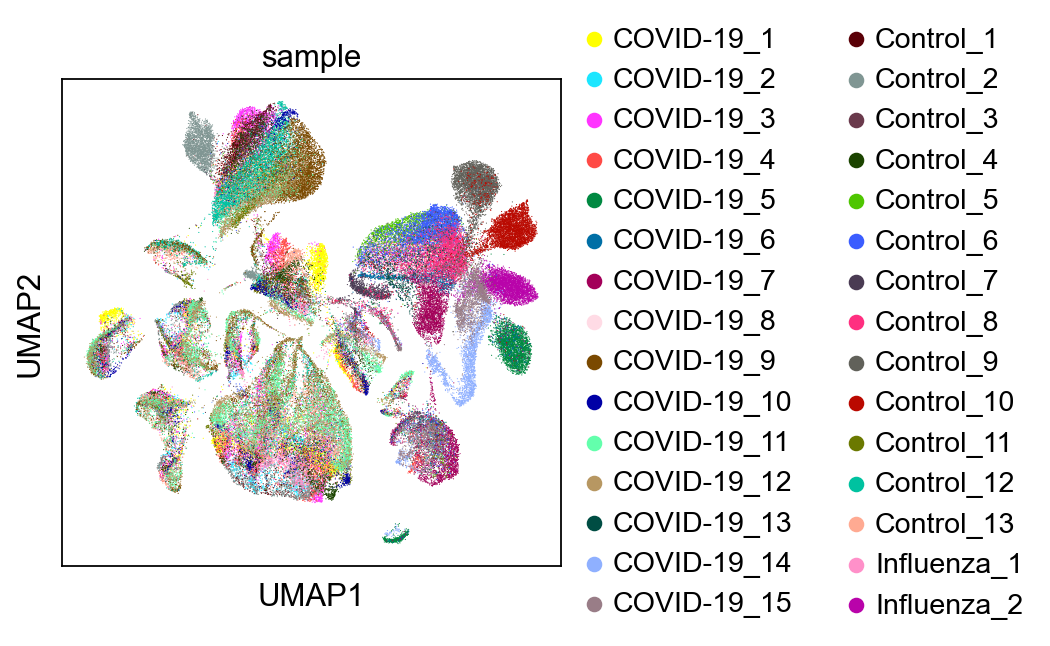

In [3]:
sc.pl.umap(adata, color='sample')

### Get centroids of each samples

In [4]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

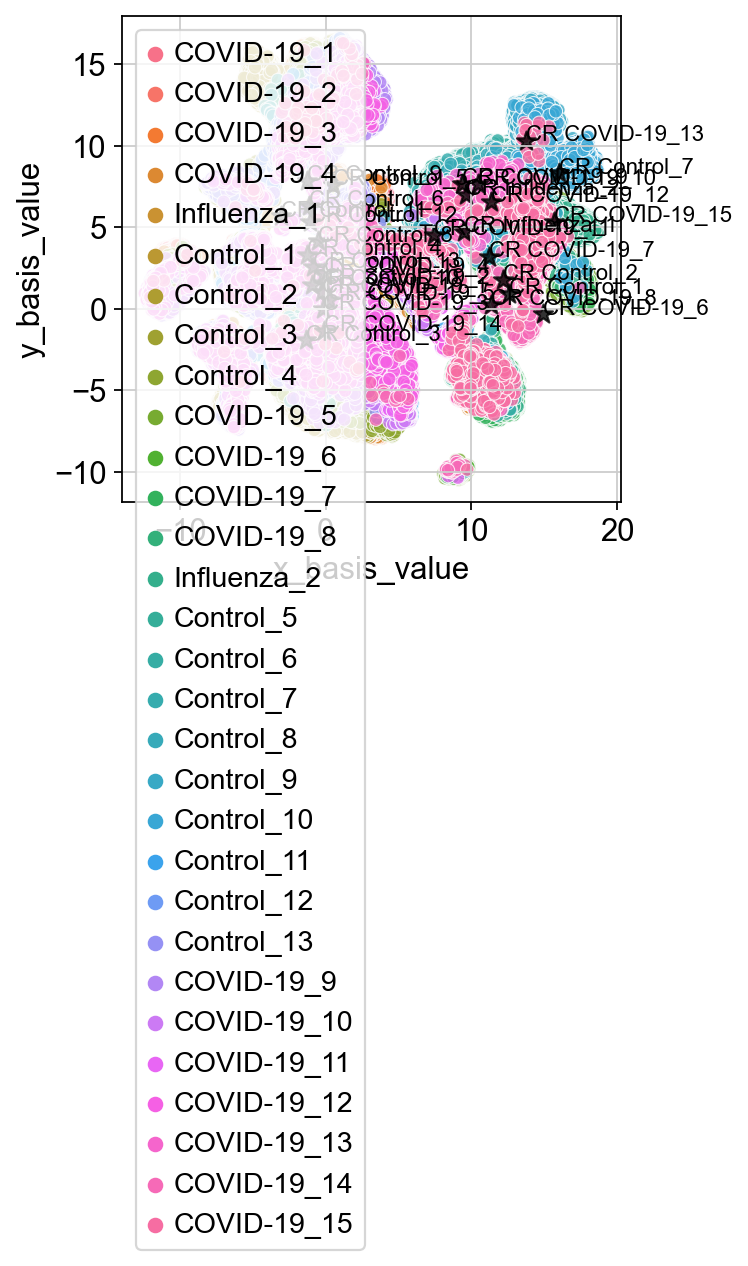

In [5]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(25, 25))
plt.legend(loc="upper left")
plt.show()

### Split samples into train and test

In [6]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7777)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test)
print()
print(f"Size of the train samples: {len(y_train)}, the test sample: {len(y_test)}")

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_13' 'COVID-19_1' 'Control_9' 'COVID-19_11' 'COVID-19_3'
 'COVID-19_15' 'Control_5' 'COVID-19_12' 'Control_6' 'Control_3'
 'COVID-19_2' 'Control_13' 'COVID-19_6' 'COVID-19_8' 'Influenza_1'
 'Control_1' 'COVID-19_7' 'Control_12' 'Control_4' 'Control_10'
 'COVID-19_10' 'COVID-19_5' 'Control_7' 'Control_2']
Samples for testing: ['Influenza_2' 'COVID-19_9' 'COVID-19_14' 'Control_8' 'COVID-19_4'
 'Control_11']

Size of the train samples: 24, the test sample: 6


## Sample Classification: Scenario 3.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Run kmeans clusterning and get clusters. Encode exsting samples (covid and non-covid) clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [7]:
umap1 = adata.obsm['X_umap'][:, 0]
umap2 = adata.obsm['X_umap'][:, 1]
sample_vector = adata.obs['sample'].values

df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
               columns =['umap1', 'umap2', 'sample'])
df

,umap1,umap2,sample
0,1.939955,-4.752501,COVID-19_1
1,-11.327367,3.537616,COVID-19_1
2,-1.533164,-3.437606,COVID-19_1
3,4.854027,1.345688,COVID-19_1
4,-3.259794,-4.839449,COVID-19_1
...,...,...,...
114696,14.855623,2.865599,COVID-19_15
114697,11.101423,-3.691802,COVID-19_15
114698,13.821174,4.935024,COVID-19_15
114699,13.454780,3.591425,COVID-19_15


In [8]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

,umap1,umap2,sample,covid_non_covid
0,1.939955,-4.752501,COVID-19_1,covid
1,-11.327367,3.537616,COVID-19_1,covid
2,-1.533164,-3.437606,COVID-19_1,covid
3,4.854027,1.345688,COVID-19_1,covid
4,-3.259794,-4.839449,COVID-19_1,covid
...,...,...,...,...
114696,14.855623,2.865599,COVID-19_15,covid
114697,11.101423,-3.691802,COVID-19_15,covid
114698,13.821174,4.935024,COVID-19_15,covid
114699,13.454780,3.591425,COVID-19_15,covid


#### Split the dataset into train: df_exist and test: df_new

In [9]:
list_samples = df['sample'].unique()

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=111)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Influenza_1' 'Control_7' 'Influenza_2' 'Control_2' 'Control_1'
 'COVID-19_11' 'Control_8' 'COVID-19_12' 'COVID-19_1' 'COVID-19_2'
 'COVID-19_6' 'COVID-19_14' 'COVID-19_10' 'Control_3' 'Control_4'
 'Control_9' 'COVID-19_3' 'COVID-19_5' 'Control_10' 'Control_13'
 'COVID-19_13' 'COVID-19_15' 'COVID-19_8' 'Control_11']
Samples for testing: ['Control_12' 'Control_5' 'COVID-19_4' 'Control_6' 'COVID-19_9'
 'COVID-19_7']


In [10]:
# Make a dataframe for training
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
df_exist

,umap1,umap2,sample,covid_non_covid
0,1.939955,-4.752501,COVID-19_1,covid
1,-11.327367,3.537616,COVID-19_1,covid
2,-1.533164,-3.437606,COVID-19_1,covid
3,4.854027,1.345688,COVID-19_1,covid
4,-3.259794,-4.839449,COVID-19_1,covid
...,...,...,...,...
114696,14.855623,2.865599,COVID-19_15,covid
114697,11.101423,-3.691802,COVID-19_15,covid
114698,13.821174,4.935024,COVID-19_15,covid
114699,13.454780,3.591425,COVID-19_15,covid


In [11]:
# Make a dataframe for testing
y_test = list(y_test)
df_new = df.query("sample == @y_test")
df_new

,umap1,umap2,sample,covid_non_covid
14893,2.747445,3.154681,COVID-19_4,covid
14894,-1.162378,-4.825221,COVID-19_4,covid
14895,-5.715297,0.878239,COVID-19_4,covid
14896,7.384730,2.150717,COVID-19_4,covid
14897,0.349497,7.849064,COVID-19_4,covid
...,...,...,...,...
95966,3.326286,13.175691,COVID-19_9,covid
95967,3.027990,14.481750,COVID-19_9,covid
95968,0.096695,5.370456,COVID-19_9,covid
95969,-6.019488,7.665164,COVID-19_9,covid


### Run Kmeans clusterning to get clusters' centroids as a cluster representation.

Also, check the elbow to determine the number of clusters (the parameter `k`).

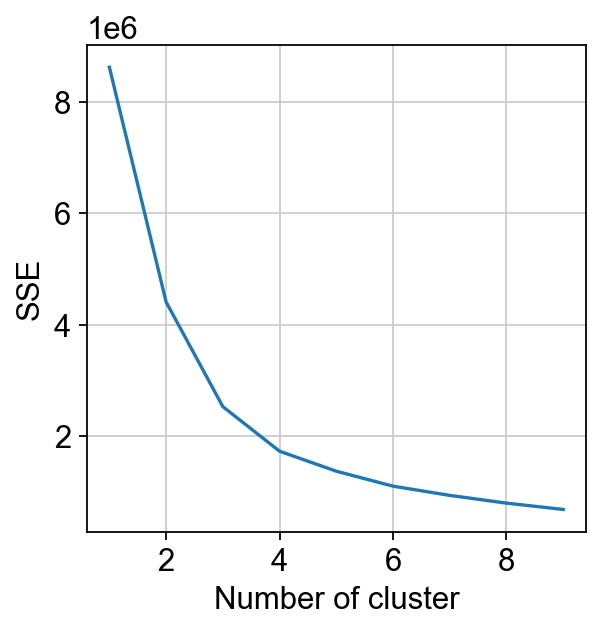

In [12]:
from sklearn.cluster import KMeans
sc.set_figure_params(figsize=None)

data = (df_exist[['umap1', 'umap2']])
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

According to the above plot, we shall use `k=3` this time.<br>
<br>

Next, train a kmeans again with `k=4`, and get distances between each centroid and each sample, and then append them to the dataframe.

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set o

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

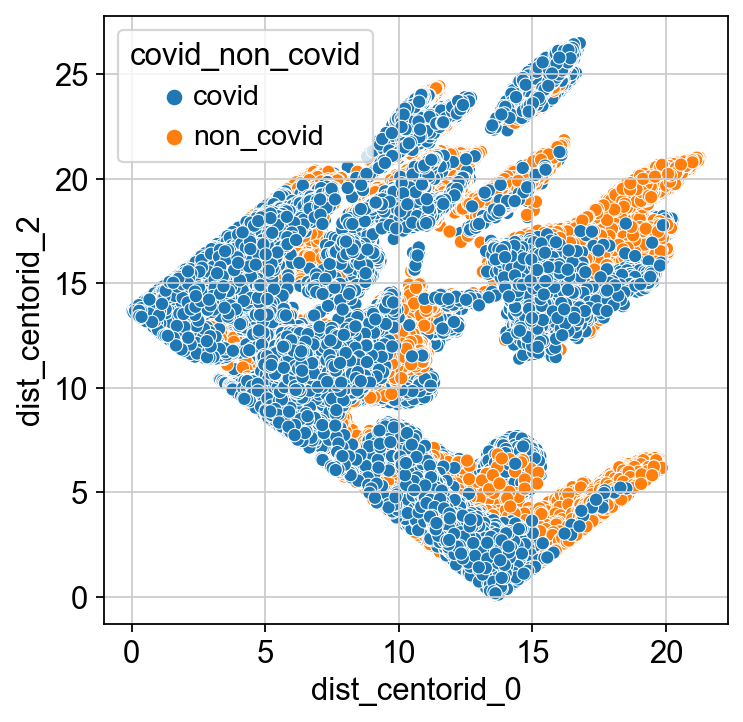

In [13]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

### Compute a distance
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

Also, print the augmented dataframe.

In [14]:
df_exist

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3
0,1.939955,-4.752501,COVID-19_1,covid,2.333784,9.125087,16.004287,15.690010
1,-11.327367,3.537616,COVID-19_1,covid,16.599915,6.528705,24.991221,12.720066
2,-1.533164,-3.437606,COVID-19_1,covid,5.321420,5.498143,17.922593,14.150369
3,4.854027,1.345688,COVID-19_1,covid,4.792062,10.893393,9.976127,10.931468
4,-3.259794,-4.839449,COVID-19_1,covid,7.207551,5.403600,20.135277,15.725542
...,...,...,...,...,...,...,...,...
114696,14.855623,2.865599,COVID-19_15,covid,12.682645,21.009341,3.693166,17.514324
114697,11.101423,-3.691802,COVID-19_15,covid,7.323472,17.403365,10.282865,18.678378
114698,13.821174,4.935024,COVID-19_15,covid,12.997264,20.400744,1.404797,15.725399
114699,13.454780,3.591425,COVID-19_15,covid,11.887652,19.748389,2.714101,15.936794


Train the augmented dataset in SVM

In [15]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

Print the dataframe for the test data/new samples

In [16]:
df_new

,umap1,umap2,sample,covid_non_covid
14893,2.747445,3.154681,COVID-19_4,covid
14894,-1.162378,-4.825221,COVID-19_4,covid
14895,-5.715297,0.878239,COVID-19_4,covid
14896,7.384730,2.150717,COVID-19_4,covid
14897,0.349497,7.849064,COVID-19_4,covid
...,...,...,...,...
95966,3.326286,13.175691,COVID-19_9,covid
95967,3.027990,14.481750,COVID-19_9,covid
95968,0.096695,5.370456,COVID-19_9,covid
95969,-6.019488,7.665164,COVID-19_9,covid


In [17]:
# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred


/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a 

In [18]:
df_new

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,y_pred
14893,2.747445,3.154681,COVID-19_4,covid,6.563630,9.290207,11.214294,8.337477,covid
14894,-1.162378,-4.825221,COVID-19_4,covid,5.171519,6.685380,18.416418,15.523538,covid
14895,-5.715297,0.878239,COVID-19_4,covid,10.390943,1.047501,19.976678,10.972797,covid
14896,7.384730,2.150717,COVID-19_4,covid,6.552743,13.518001,7.401263,11.839496,covid
14897,0.349497,7.849064,COVID-19_4,covid,11.691924,10.170145,13.250940,3.073083,covid
...,...,...,...,...,...,...,...,...,...
95966,3.326286,13.175691,COVID-19_9,covid,16.508212,16.225319,12.284881,4.824852,covid
95967,3.027990,14.481750,COVID-19_9,covid,17.824011,17.155937,13.294204,5.393225,covid
95968,0.096695,5.370456,COVID-19_9,covid,9.447163,8.174946,13.445983,5.400825,covid
95969,-6.019488,7.665164,COVID-19_9,covid,14.730125,7.811174,19.576963,6.024783,non_covid


In [19]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if 'covid' in sample or 'COVID' in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'COVID-19_4': [3890, 671], 'COVID-19_7': [4922, 97], 'Control_5': [1975, 510], 'Control_6': [2249, 1745], 'Control_12': [2674, 4132], 'COVID-19_9': [5865, 960]}


In [20]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666


## Sample Classification: Scenario 3.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [27]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'umap1', 'umap2'])

In [28]:
df

,basis_value,sample,umap1,umap2
0,"[1.9399555, -4.7525005]",COVID-19_1,1.939955,-4.752501
1,"[-11.327367, 3.5376163]",COVID-19_1,-11.327367,3.537616
2,"[-1.5331637, -3.4376059]",COVID-19_1,-1.533164,-3.437606
3,"[4.8540273, 1.3456876]",COVID-19_1,4.854027,1.345688
4,"[-3.2597935, -4.8394494]",COVID-19_1,-3.259794,-4.839449
...,...,...,...,...
114696,"[14.855623, 2.8655987]",COVID-19_15,14.855623,2.865599
114697,"[11.101423, -3.6918018]",COVID-19_15,11.101423,-3.691802
114698,"[13.821174, 4.935024]",COVID-19_15,13.821174,4.935024
114699,"[13.45478, 3.5914252]",COVID-19_15,13.454780,3.591425


In [32]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_6875/2981173161.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_6875/2981173161.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_6875/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_6875/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_6875/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

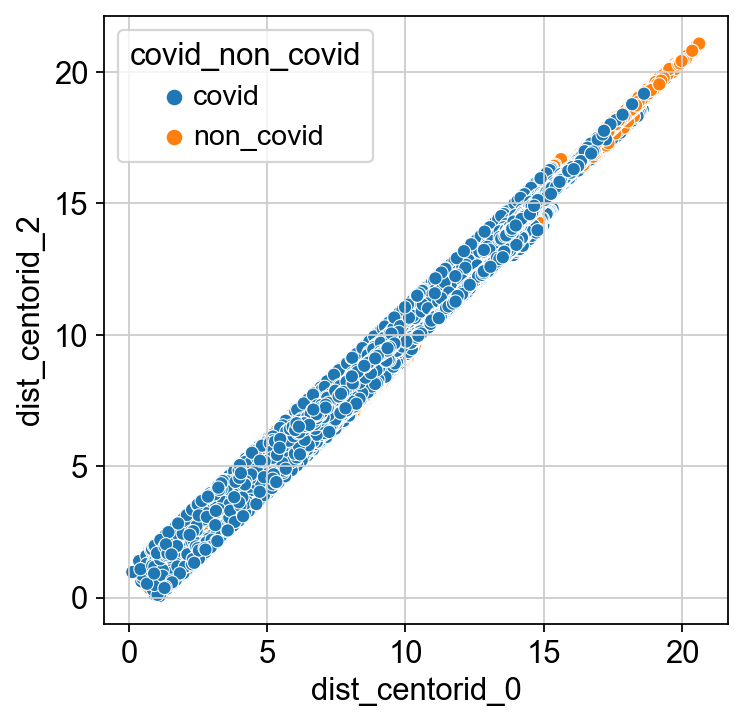

In [33]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [34]:
df_exist

,basis_value,sample,umap1,umap2,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,dist_centorid_4,...,dist_centorid_14,dist_centorid_15,dist_centorid_16,dist_centorid_17,dist_centorid_18,dist_centorid_19,dist_centorid_20,dist_centorid_21,dist_centorid_22,dist_centorid_23
0,"[1.9399555, -4.7525005]",COVID-19_1,1.939955,-4.752501,covid,6.177470,6.621453,5.177660,7.271369,12.110026,...,13.003040,6.840803,11.572044,10.543294,7.824725,14.462301,15.030092,10.769148,19.135243,3.975037
1,"[-11.327367, 3.5376163]",COVID-19_1,-11.327367,3.537616,covid,11.318091,11.407058,11.673170,11.264366,20.844204,...,10.941745,10.601524,8.523451,10.381011,10.470564,21.091176,22.158538,18.746394,25.989605,12.212292
2,"[-1.5331637, -3.4376059]",COVID-19_1,-1.533164,-3.437606,covid,4.612712,5.189323,3.637809,5.821293,13.708663,...,11.288664,4.930524,9.243081,8.789799,6.007373,15.550378,16.316125,11.967396,20.556627,2.493773
3,"[4.8540273, 1.3456876]",COVID-19_1,4.854027,1.345688,covid,5.161229,4.953260,5.259327,5.070015,5.729202,...,8.932457,5.787266,9.035576,7.174279,5.880663,7.757880,8.419229,4.075658,12.627583,5.686127
4,"[-3.2597935, -4.8394494]",COVID-19_1,-3.259794,-4.839449,covid,6.553968,7.128883,5.677274,7.712911,15.930823,...,12.842469,6.712108,10.516774,10.406842,7.743090,17.762004,18.536154,14.189373,22.778260,4.665845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114696,"[14.855623, 2.8655987]",COVID-19_15,14.855623,2.865599,covid,15.265319,15.008609,15.352088,15.010687,5.683870,...,16.878189,15.850596,18.150920,16.150887,15.763795,7.298049,6.495416,7.647383,7.500652,15.584680
114697,"[11.101423, -3.6918018]",COVID-19_15,11.101423,-3.691802,covid,12.327693,12.362126,11.891955,12.699540,8.567278,...,16.918312,13.088512,16.993015,15.185023,13.525664,11.488553,11.347857,9.023541,14.231658,11.482483
114698,"[13.821174, 4.935024]",COVID-19_15,13.821174,4.935024,covid,14.653720,14.322389,14.896442,14.224651,4.343234,...,15.370144,15.157972,16.913845,14.931039,14.919921,5.232503,4.321596,6.441138,5.352554,15.320642
114699,"[13.45478, 3.5914252]",COVID-19_15,13.454780,3.591425,covid,13.991723,13.703005,14.148184,13.665248,4.129158,...,15.328067,14.544556,16.662104,14.663938,14.398197,5.777421,5.040415,6.135146,6.703349,14.473894


In [35]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['basis_value', 'sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [55]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_49932/3163315646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_49932/3163315646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['y_pred'] = y_pred


In [59]:
y_true = y_test.to_list()

In [60]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.5068413952592021
Precision: 0.5068413952592021
Recall: 0.5068413952592021


## Sample Classification: Scenario 3.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [47]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'umap1', 'umap2'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

In [48]:
df

,basis_value,sample,umap1,umap2
0,"[1.9399555, -4.7525005]",COVID-19_1,1.939955,-4.752501
1,"[-11.327367, 3.5376163]",COVID-19_1,-11.327367,3.537616
2,"[-1.5331637, -3.4376059]",COVID-19_1,-1.533164,-3.437606
3,"[4.8540273, 1.3456876]",COVID-19_1,4.854027,1.345688
4,"[-3.2597935, -4.8394494]",COVID-19_1,-3.259794,-4.839449
...,...,...,...,...
114696,"[14.855623, 2.8655987]",COVID-19_15,14.855623,2.865599
114697,"[11.101423, -3.6918018]",COVID-19_15,11.101423,-3.691802
114698,"[13.821174, 4.935024]",COVID-19_15,13.821174,4.935024
114699,"[13.45478, 3.5914252]",COVID-19_15,13.454780,3.591425


In [49]:
# umap1 = adata.obsm['X_umap'][:, 0]
# umap2 = adata.obsm['X_umap'][:, 1]
# sample_vector = adata.obs['sample'].values

# df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
#                columns =['umap1', 'umap2', 'sample'])
# df

In [50]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

,basis_value,sample,umap1,umap2,covid_non_covid
0,"[1.9399555, -4.7525005]",COVID-19_1,1.939955,-4.752501,covid
1,"[-11.327367, 3.5376163]",COVID-19_1,-11.327367,3.537616,covid
2,"[-1.5331637, -3.4376059]",COVID-19_1,-1.533164,-3.437606,covid
3,"[4.8540273, 1.3456876]",COVID-19_1,4.854027,1.345688,covid
4,"[-3.2597935, -4.8394494]",COVID-19_1,-3.259794,-4.839449,covid
...,...,...,...,...,...
114696,"[14.855623, 2.8655987]",COVID-19_15,14.855623,2.865599,covid
114697,"[11.101423, -3.6918018]",COVID-19_15,11.101423,-3.691802,covid
114698,"[13.821174, 4.935024]",COVID-19_15,13.821174,4.935024,covid
114699,"[13.45478, 3.5914252]",COVID-19_15,13.454780,3.591425,covid


In [51]:
list_samples = df['sample'].unique()

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=111)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Influenza_1' 'Control_7' 'Influenza_2' 'Control_2' 'Control_1'
 'COVID-19_11' 'Control_8' 'COVID-19_12' 'COVID-19_1' 'COVID-19_2'
 'COVID-19_6' 'COVID-19_14' 'COVID-19_10' 'Control_3' 'Control_4'
 'Control_9' 'COVID-19_3' 'COVID-19_5' 'Control_10' 'Control_13'
 'COVID-19_13' 'COVID-19_15' 'COVID-19_8' 'Control_11']
Samples for testing: ['Control_12' 'Control_5' 'COVID-19_4' 'Control_6' 'COVID-19_9'
 'COVID-19_7']


In [54]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/2981173161.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/2981173161.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set o

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

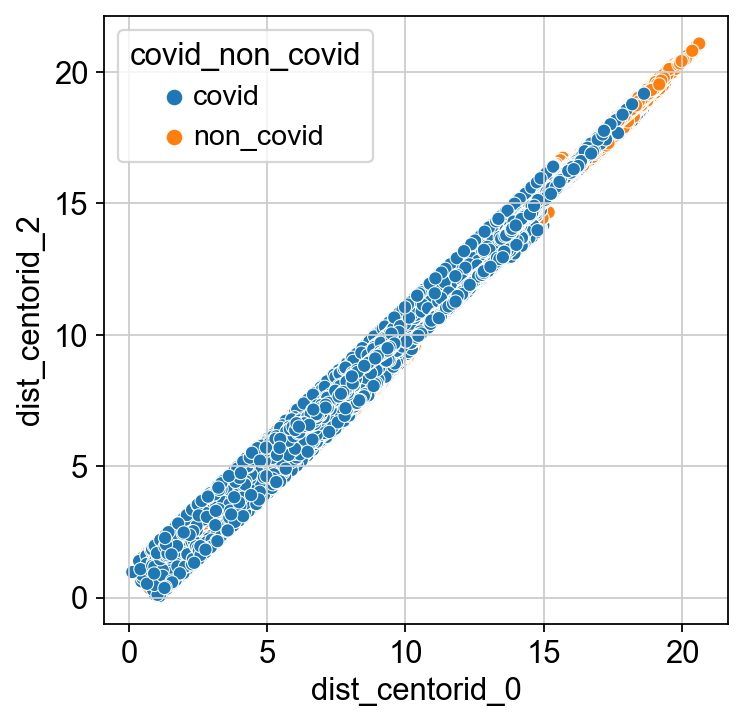

In [55]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [56]:
df_exist

,basis_value,sample,umap1,umap2,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,dist_centorid_4,...,dist_centorid_14,dist_centorid_15,dist_centorid_16,dist_centorid_17,dist_centorid_18,dist_centorid_19,dist_centorid_20,dist_centorid_21,dist_centorid_22,dist_centorid_23
0,"[1.9399555, -4.7525005]",COVID-19_1,1.939955,-4.752501,covid,6.177470,6.621453,5.177660,7.271369,12.110026,...,9.207074,6.840803,11.572044,10.543294,7.824725,10.769148,14.686447,19.135243,3.975037,17.032805
1,"[-11.327367, 3.5376163]",COVID-19_1,-11.327367,3.537616,covid,11.318091,11.407058,11.673170,11.264366,20.844204,...,10.830809,10.601524,8.523451,10.381011,10.470564,18.746394,22.849324,25.989605,12.212292,27.062157
2,"[-1.5331637, -3.4376059]",COVID-19_1,-1.533164,-3.437606,covid,4.612712,5.189323,3.637809,5.821293,13.708663,...,7.628204,4.930524,9.243081,8.789799,6.007373,11.967396,16.277253,20.556627,2.493773,19.308976
3,"[4.8540273, 1.3456876]",COVID-19_1,4.854027,1.345688,covid,5.161229,4.953260,5.259327,5.070015,5.729202,...,6.041991,5.787266,9.035576,7.174279,5.880663,4.075658,8.299912,12.627583,5.686127,11.528413
4,"[-3.2597935, -4.8394494]",COVID-19_1,-3.259794,-4.839449,covid,6.553968,7.128883,5.677274,7.712911,15.930823,...,9.373144,6.712108,10.516774,10.406842,7.743090,14.189373,18.500846,22.778260,4.665845,21.488643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114696,"[14.855623, 2.8655987]",COVID-19_15,14.855623,2.865599,covid,15.265319,15.008609,15.352088,15.010687,5.683870,...,15.419228,15.850596,18.150920,16.150887,15.763795,7.647383,5.101142,7.500652,15.584680,2.586946
114697,"[11.101423, -3.6918018]",COVID-19_15,11.101423,-3.691802,covid,12.327693,12.362126,11.891955,12.699540,8.567278,...,13.997664,13.088512,16.993015,15.185023,13.525664,9.023541,10.239864,14.231658,11.482483,10.105541
114698,"[13.821174, 4.935024]",COVID-19_15,13.821174,4.935024,covid,14.653720,14.322389,14.896442,14.224651,4.343234,...,14.356548,15.157972,16.913845,14.931039,14.919921,6.441138,2.972301,5.352554,15.320642,1.894246
114699,"[13.45478, 3.5914252]",COVID-19_15,13.454780,3.591425,covid,13.991723,13.703005,14.148184,13.665248,4.129158,...,13.977187,14.544556,16.662104,14.663938,14.398197,6.135146,3.643023,6.703349,14.473894,2.814022


In [57]:
from sklearn.svm import SVC

# Prepare training data for building the model
# Use only the new features: distance value between the cell and the sample's centroid.
X_train = df_exist.drop(['basis_value', 'sample', 'umap1', 'umap2','covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [58]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'umap1', 'umap2', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/149374088.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/149374088.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_18736/149374088.py:14: SettingWithCopyWarning: 
A value is trying to be set on a 

In [59]:
y_true = y_test.to_list()

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.6767935331761535
Precision: 0.6767935331761535
Recall: 0.6767935331761535
